In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(color_codes=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.10.1


## Load the data

In [3]:
df = pd.read_csv('../cleaned_data/FREN.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,0.262912,0.323930,0.330964,-0.283181,1.816790,2.044664,2.114615,0.901276,1.086567,1.104971,0.0,0.5,0.5,-1.0,0.594005,0.066667,0.592593,0.992469
2012-10-18,0.363756,0.367853,0.372052,2.890247,0.762637,1.044525,1.193857,0.927216,1.134364,1.199147,0.5,0.5,0.5,-1.0,0.599455,0.133333,0.592593,0.659136
2012-10-19,0.421380,0.384324,0.390179,3.048546,0.943685,1.220859,1.368199,0.490172,0.559098,0.597600,1.0,0.5,0.5,-1.0,0.604905,0.200000,0.592593,0.787341
2012-10-22,0.497013,0.413606,0.413140,3.232585,0.871368,1.153974,1.305792,0.334589,0.356089,0.297172,-1.0,0.5,0.5,-1.0,0.621253,0.400000,0.629630,0.761700
2012-10-23,0.561840,0.442888,0.425224,3.196894,0.645525,0.952478,1.119480,0.295777,0.309812,0.308451,-0.5,0.5,0.5,-1.0,0.626703,0.466667,0.629630,0.684777


### Plot the Close price - our target

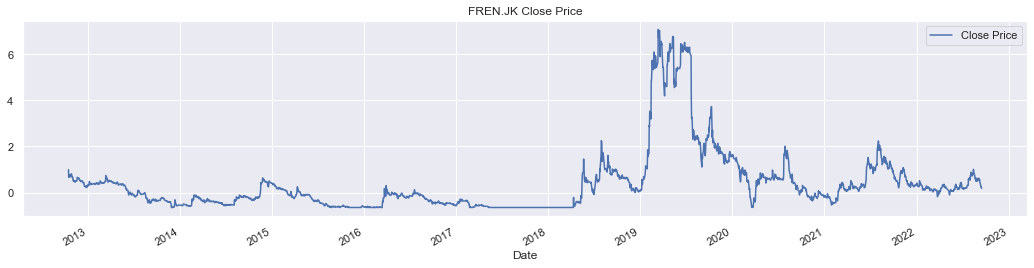

In [4]:
df['Close'].plot(figsize=(18, 4))
plt.legend(['Close Price'])
plt.title('FREN.JK Close Price')
plt.show()

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [5]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [6]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Modeling

### Regression with Deep Neural Network

In [7]:
from utils import build_and_compile_model, fit_model

In [8]:
from utils import genPredictions, inversePredsAndAct, evaluateModel

In [9]:
from joblib import load

close_scaler = load('../feature_engineering/fren_close_scaler.bin')

In [10]:
epochs_cands = [100,150,200]
batch_size_cands = [32,64,128]
performances = {}
models = {}
predictions_dfs = {}
inversed_dfs = {}

modelID = 1
for epochs in epochs_cands:
    for batch_size in batch_size_cands:
        print(f'\n==========MODEL {modelID} with epochs: {epochs} and batch size: {batch_size}==========')
        model = build_and_compile_model(17)
        history = fit_model(model, epochs, batch_size, train_features, train_labels)
        models[f'Model-{modelID}'] = (model, history)
        predictions = genPredictions(model, df, test_features, train_len)
        predictions_dfs[f'Model-{modelID}'] = predictions
        
        inversed = inversePredsAndAct(predictions, close_scaler, test_labels)
        inversed_dfs[f'Model-{modelID}'] = inversed
        rmse_, mape_, rsquared_ = evaluateModel(inversed)
        performances[f'Model-{modelID}'] = {
            'Epochs': epochs,
            'Batch Size': batch_size,
            'RMSE': rmse_,
            'MAPE': mape_,
            'R2': rsquared_
        }
        
        modelID += 1
        


==========MODEL 1 with epochs: 100 and batch size: 32==========
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
None
16/16 [==============================] - 0s 1ms/step

==========MODEL 2 with epochs: 100 and batch size: 64==========
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape 

Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
None
16/16 [==============================] - 0s 2ms/step


In [11]:
performance_df = pd.DataFrame(performances).transpose()
performance_df[['Epochs', 'Batch Size']] = performance_df[['Epochs', 'Batch Size']].astype(int)
performance_df.head(9)

,Epochs,Batch Size,RMSE,MAPE,R2
Model-1,100,32,5.277729,3.838714,0.924066
Model-2,100,64,4.402198,3.369650,0.947170
Model-3,100,128,5.277147,3.759605,0.924082
Model-4,150,32,4.808815,3.179224,0.936959
Model-5,150,64,4.736608,4.020002,0.938838
Model-6,150,128,5.184019,3.852980,0.926738
Model-7,200,32,4.988565,3.403961,0.932159
Model-8,200,64,5.505822,4.169153,0.917360
Model-9,200,128,4.729437,3.913244,0.939023


### Plot the best model

In [12]:
from utils import plotPredAct, plotErrorHist

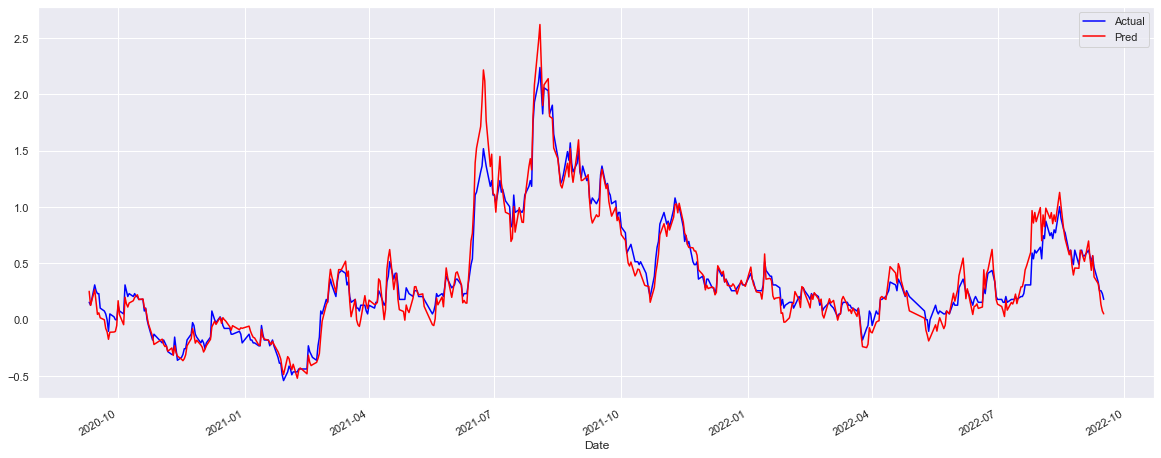

In [13]:
plotPredAct(predictions_dfs['Model-2'])

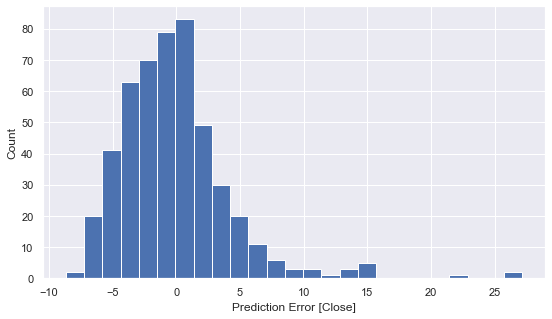

In [14]:
plt.figure(figsize=(9,5))
plotErrorHist(inversed_dfs['Model-2'])

### Save the best model

In [15]:
models['Model-2'][0].save('./models/fren.h5')

In [16]:
loadedModel = keras.models.load_model('./models/fren.h5')

In [17]:
loadedModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1152      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
